## Objectif

L’objectif de ce notebook est d’évaluer la faisabilité d’une classification
automatique des produits à partir de leurs images, en utilisant des descripteurs
visuels classiques (ORB), sans recourir au deep learning.

L’analyse repose sur une représentation en 2D des images, une visualisation
des regroupements par catégorie réelle, et une évaluation via clustering non supervisé.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf

2026-01-08 10:10:33.124314: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-08 10:10:33.233633: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767863433.281179    5942 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767863433.294385    5942 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-08 10:10:33.402641: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
DATA_PATH = "../data/Flipkart/flipkart_com-ecommerce_sample_1050.csv"

df = pd.read_csv(DATA_PATH)
df.head()


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [3]:
df = df[[
    "image",
    "product_category_tree"
]]


In [4]:
df["category"] = df["product_category_tree"].apply(
    lambda x: x.split(">>")[0].replace('[\"', '').strip()
)

df["category"].value_counts()


category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

(np.float64(-0.5), np.float64(3599.5), np.float64(3599.5), np.float64(-0.5))

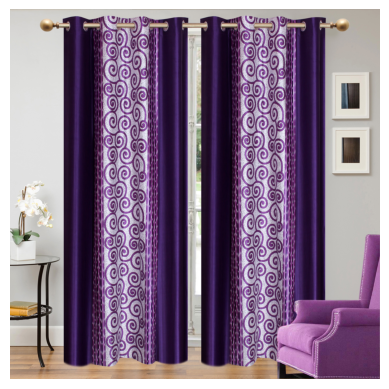

In [5]:
IMAGE_DIR = "../data/Flipkart/Images"

def load_image(img_name):
    path = os.path.join(IMAGE_DIR, img_name)
    img = cv2.imread(path)
    if img is None:
        return None
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Exemple d’image
img_example = load_image(df.iloc[0]["image"])
plt.imshow(img_example)
plt.axis("off")


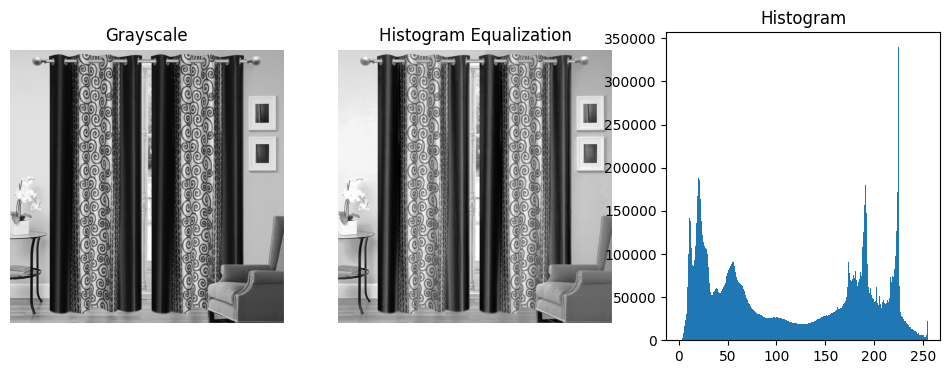

In [6]:
gray = cv2.cvtColor(img_example, cv2.COLOR_RGB2GRAY)
equalized = cv2.equalizeHist(gray)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(gray, cmap="gray")
plt.title("Grayscale")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(equalized, cmap="gray")
plt.title("Histogram Equalization")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.hist(gray.ravel(), bins=256)
plt.title("Histogram")
plt.show()


In [7]:
orb = cv2.ORB_create(nfeatures=500)

def extract_orb_descriptors(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    keypoints, descriptors = orb.detectAndCompute(gray, None)
    return descriptors


In [8]:
descriptors_list = []

valid_indices = []

for idx, row in df.iterrows():
    img = load_image(row["image"])
    if img is None:
        continue
    desc = extract_orb_descriptors(img)
    if desc is not None:
        descriptors_list.append(desc)
        valid_indices.append(idx)

len(descriptors_list)


1049

In [9]:
import numpy as np
from sklearn.cluster import KMeans

all_descriptors = np.vstack(descriptors_list)

kmeans = KMeans(n_clusters=50, random_state=42)
kmeans.fit(all_descriptors)


,n_clusters,50
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [10]:
def build_bovw(descriptors, kmeans, n_clusters):
    hist = np.zeros(n_clusters)
    if descriptors is not None:
        labels = kmeans.predict(descriptors)
        for l in labels:
            hist[l] += 1
    return hist

X_bovw = np.array([
    build_bovw(desc, kmeans, 50)
    for desc in descriptors_list
])

X_bovw.shape


(1049, 50)

In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score

y_img = df.loc[valid_indices, "category"]

X_pca = PCA(n_components=30, random_state=42).fit_transform(X_bovw)
X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_pca)

kmeans_img = KMeans(n_clusters=7, random_state=42)
clusters_img = kmeans_img.fit_predict(X_tsne)

ari_img = adjusted_rand_score(y_img, clusters_img)
ari_img


0.03775568613216741

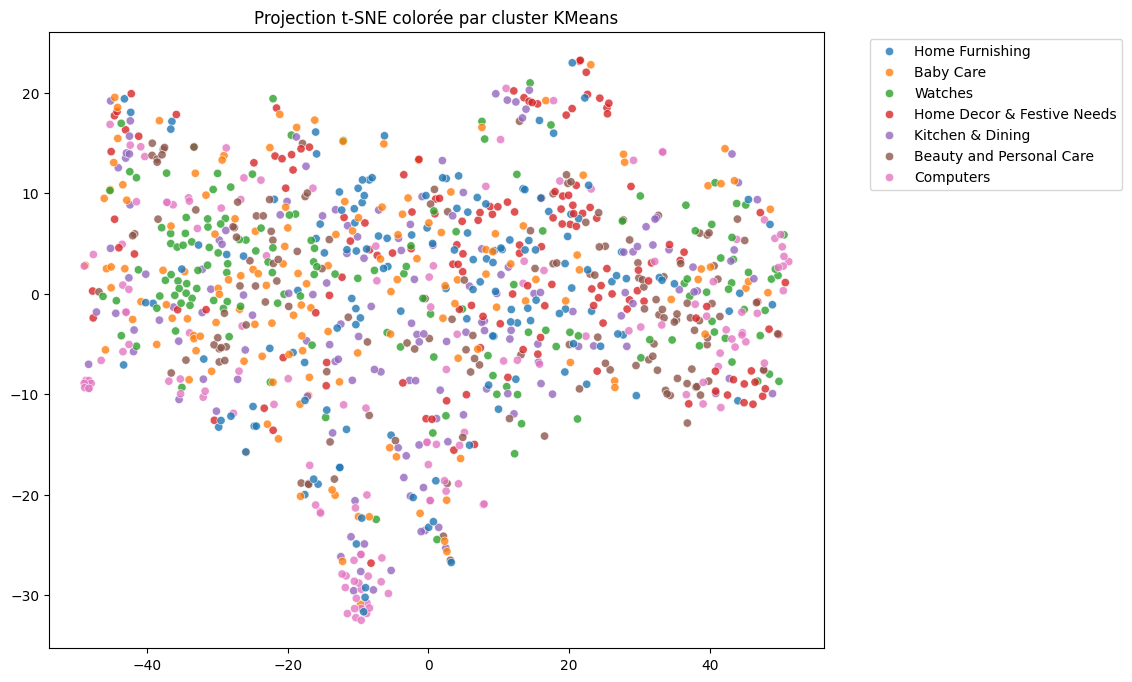

In [13]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=y_img,
    palette="tab10",
    alpha=0.8
)
plt.title("Projection t-SNE colorée par cluster KMeans")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

Le score ARI obtenu (≈ 0.04) confirme l’absence de correspondance significative
entre les clusters issus des descripteurs ORB et les catégories produits réelles.

Cette observation est cohérente avec la visualisation t-SNE et met en évidence
les limites des approches basées sur des descripteurs locaux pour capturer
la sémantique globale des images de produits e-commerce.

Ces résultats justifient le recours à des approches basées sur le deep learning,
capables d’apprendre des représentations visuelles plus abstraites et discriminantes.
